In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from lrfinder import LRFinder

In [2]:
%config InlineBackend.figure_format = 'retina'

## Load Dataset

In [3]:
BATCH = 32

In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [5]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.shuffle(buffer_size=len(train_images))
train_ds = train_ds.batch(BATCH)
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)


test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_ds = test_ds.batch(BATCH)
test_ds = test_ds.prefetch(tf.data.experimental.AUTOTUNE)

In [6]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

## Find Learning Rate

In [7]:
steps_per_epoch = np.ceil(len(train_images) / BATCH)

In [8]:
lr_finder = LRFinder(model)
lr_finder.find(train_ds, start_lr=0.0001, end_lr=1, epochs=5,
               steps_per_epoch=steps_per_epoch, batch_size=BATCH)

Epoch 1/5
1875/1875 [==============================] - 3s 1ms/step - loss: 9.6267 - accuracy: 0.7211
Epoch 2/5
1875/1875 [==============================] - 3s 1ms/step - loss: 1.1323 - accuracy: 0.6616
Epoch 3/5
1875/1875 [==============================] - 3s 1ms/step - loss: 1.8898 - accuracy: 0.3248
Epoch 4/5
1875/1875 [==============================] - 3s 1ms/step - loss: 2.6922 - accuracy: 0.1001
Epoch 5/5
1875/1875 [==============================] - 3s 1ms/step - loss: 2.4605 - accuracy: 0.1013


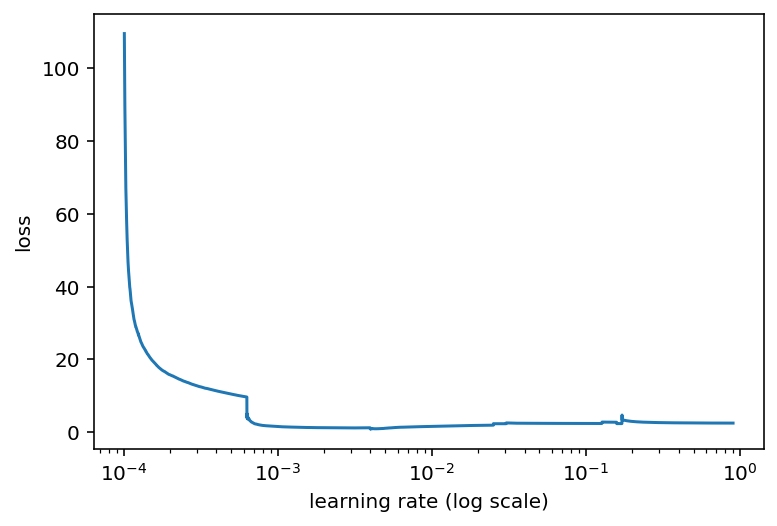

In [9]:
lr_finder.plot_loss()

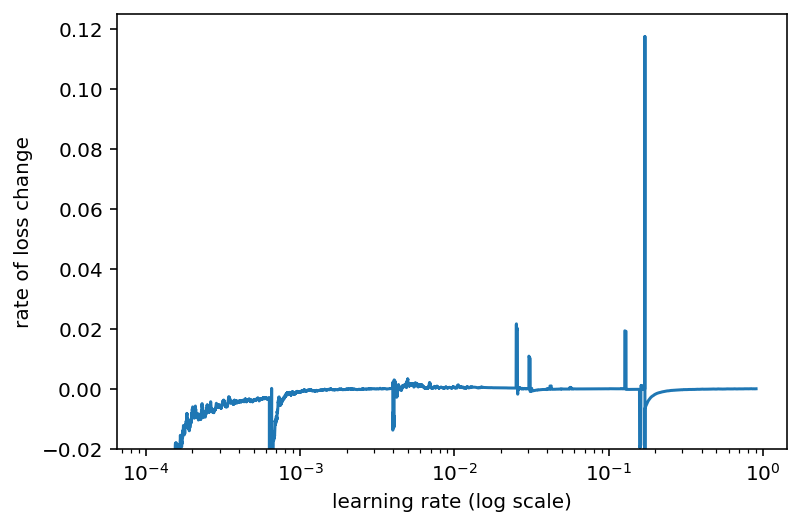

In [14]:
lr_finder.plot_loss_change(sma=20, n_skip_beginning=20, n_skip_end=5, y_lim=(-0.02, 0.125))